<a href="https://colab.research.google.com/github/minhquan186/edge-upper-endoscopy-imaging/blob/master/MobileNetv2_(quantized)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


# Setup


In [2]:
!pip install imutils
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 213 kB 5.2 MB/s 


In [3]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import tensorflow as tf
import keras

from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
#from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#from keras.preprocessing.image import ImageDataGenerator
import imutils
import itertools

import pathlib


In [4]:
!git clone https://github.com/minhquan186/edge-upper-endoscopy-imaging.git

Cloning into 'edge-upper-endoscopy-imaging'...
remote: Enumerating objects: 3704, done.
remote: Total 3704 (delta 0), reused 0 (delta 0), pack-reused 3704
Receiving objects: 100% (3704/3704), 409.88 MiB | 39.91 MiB/s, done.
Checking out files: 100% (3701/3701), done.


In [5]:
folder_path="/content/edge-upper-endoscopy-imaging/data_NICS"
class_names = ['1 Hầu họng', '2 Thực quản', '3 Tâm vị', '4 Thân vị','5 Phình vị',
               '6 Hang vị','7 Bờ cong lớn','8 Bờ cong nhỏ','9 Hành tá tràng','10 Tá tràng']
folder_names = ['Vung hau hong', 'Thuc quan', 'Tam vi', 'Than vi','Phinh vi',
               'Hang vi','Bo cong lon','Bo cong nho','Hanh ta trang','Ta trang']
nb_classes = len(class_names)

In [6]:
print(nb_classes)

10


In [7]:
Train_SIZE = 128
Test_SIZE = 128
EPOCHS = 50

# Load Image


In [8]:
def loadimage(dataset, IMAGE_SIZE=Test_SIZE):
    images = []
    labels = []
    count =0
    for i in range(nb_classes):
        label = i
        fold = f'{folder_path}/{dataset}/{class_names[i]}'
        for file in tqdm(os.listdir(fold)):
            img_path = os.path.join(fold, file)
            image = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)
            # image = cv2.cvtColor(image, cv2.COLOR_2RGB)
            image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype = 'int32')
    labels = np.array(labels, dtype = 'int32')
    return images, labels
def load_augmented_image(datasets, IMAGE_SIZE=Test_SIZE):
    images = []
    labels = []
    count =0
    ord = 0
    for dataset in datasets:
        for i in range(nb_classes):
            label = i
            fold = f'{dataset}/{folder_names[i]}'
            for file in tqdm(os.listdir(fold)):
                if dataset==datasets[0]:
                    img_path = os.path.join(fold, file)
                    image = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)
                    # image = cv2.cvtColor(image, cv2.COLOR_2RGB)
                    image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
                    images.append(image)
                    labels.append(label)
                elif ((dataset==datasets[1]) & (len(file)>8)):
                    img_path = os.path.join(fold, file)
                    image = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)
                    # image = cv2.cvtColor(image, cv2.COLOR_2RGB)
                    image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
                    images.append(image)
                    labels.append(label)
    images = np.array(images, dtype = 'int32')
    labels = np.array(labels, dtype = 'int32')
    return images, labels

import pickle

def _save_pkl(path, obj):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)
def _load_pkl(path):
  with open(path, 'rb') as f:
    obj = pickle.load(f)
  return obj

In [9]:
NICS_images, NICS_labels = loadimage('train')
# val_images, val_labels = loadimage('train')
# print(len(NICS_images))

100%|██████████| 296/296 [00:04<00:00, 62.31it/s]


In [10]:
# BAC_images, BAC_labels = load_augmented_image(['/content/drive/MyDrive/Nội soi dạ dày/augment_BAC'], Train_SIZE)
# aff_images, aff_labels = load_augmented_image(['/content/drive/MyDrive/Nội soi dạ dày/augment_aff'])
# VAE_images, VAE_labels = load_augmented_image(['/content/drive/MyDrive/Nội soi dạ dày/Data_augmented_VAE'], Train_SIZE)
# BACaff_images, BACaff_labels = load_augmented_image(['/content/drive/MyDrive/augment_aff',
#                                                      '/content/drive/MyDrive/augment_BAC'], Train_SIZE)
# print(len(BAC_images))
# print(len(aff_images))
# print(len(VAE_images))
# print(len(BACaff_images))

In [11]:
# train_images, train_labels = loadimage('train')
test_images, test_labels = loadimage('test')
# print(len(train_images))
print(len(test_images))

100%|██████████| 74/74 [00:01<00:00, 60.66it/s]


740


In [12]:
# train_images[1000].shape

In [13]:
# plt.imshow(train_images[1000])

In [14]:
# Lưu lại các files
# _save_pkl('/content/drive/MyDrive/Nội soi dạ dày/BAC_images', BAC_images)
# _save_pkl('/content/drive/MyDrive/Nội soi dạ dày/BAC_labels', BAC_labels)
# _save_pkl('/content/drive/MyDrive/Nội soi dạ dày/aff_images', aff_images)
# _save_pkl('/content/drive/MyDrive/Nội soi dạ dày/aff_labels', aff_labels)
# _save_pkl('/content/drive/MyDrive/Nội soi dạ dày/VAE_images', VAE_images)
# _save_pkl('/content/drive/MyDrive/Nội soi dạ dày/VAE_labels', VAE_labels)
# _save_pkl('/content/drive/MyDrive/MICA/BACaff_images_quant', BACaff_images)
# _save_pkl('/content/drive/MyDrive/MICA/BACaff_labels_quant', BACaff_labels)

In [15]:
# Load lại dữ liệu
train_images = _load_pkl('/content/drive/MyDrive/MICA/BACaff_images')
train_labels = _load_pkl('/content/drive/MyDrive/MICA/BACaff_labels')
# train_images = _load_pkl('/content/drive/MyDrive/MICA/BACaff_images_quant')
# train_labels = _load_pkl('/content/drive/MyDrive/MICA/BACaff_labels_quant')

In [16]:
# images, labels = shuffle(images, labels, random_state=10)

# train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2, stratify = labels)
# train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size = 0.05, stratify = train_labels)
_, val_images, _, val_labels = train_test_split(NICS_images, NICS_labels, test_size=0.2, stratify = NICS_labels)

In [17]:
print("Training images: {}".format(train_images.shape))
print("Training labels: {}".format(train_labels.shape))
print("Validation images: {}".format(val_images.shape))
print("Validation labels: {}".format(val_labels.shape))
print("Test images: {}".format(test_images.shape))
print("Test labels: {}".format(test_labels.shape))

Training images: (29089, 128, 128, 3)
Training labels: (29089,)
Validation images: (592, 128, 128, 3)
Validation labels: (592,)
Test images: (740, 128, 128, 3)
Test labels: (740,)


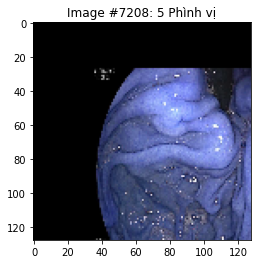

In [18]:
#hiển thị train image  
index = np.random.randint(train_images.shape[0])
plt.figure()
plt.imshow(train_images[index])
plt.title('Image #{}: '.format(index) + class_names[train_labels[index]])
plt.show()
    

Text(0.5, 1.0, 'Ground Truth : 6')

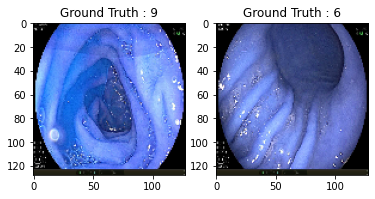

In [19]:
# Ground truth
# Hiển thị ảnh từ train data
plt.subplot(121)
index = np.random.randint(train_images.shape[0])
plt.imshow(train_images[index,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[index]))

# Hiển thị ảnh từ test data
plt.subplot(122)
index = np.random.randint(test_images.shape[0])
plt.imshow(test_images[index,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[index]))



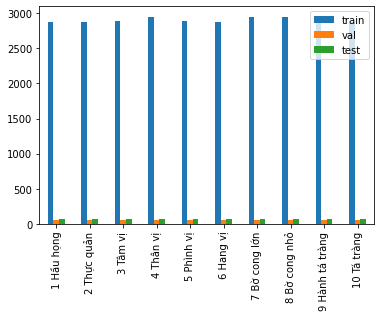

In [20]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

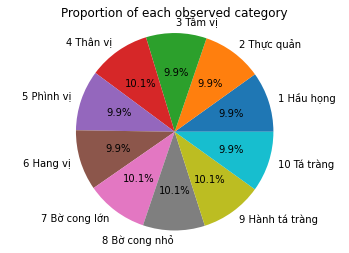

In [21]:
plt.pie(train_counts,
        explode= np.zeros(nb_classes) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

29089


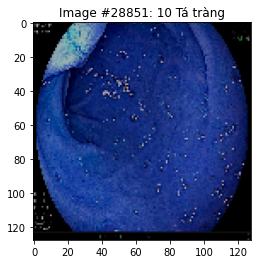

In [22]:
def display_random_image (class_names, images, labels):
    print(len(images))
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

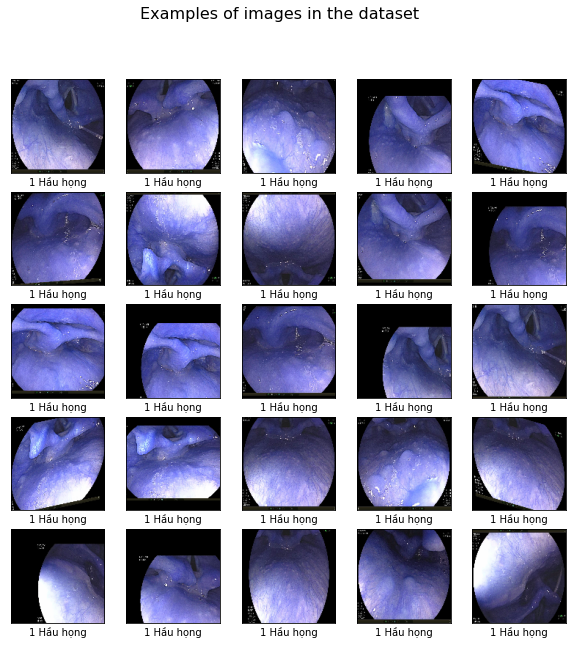

In [23]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

In [24]:
#Normalization
train_images = train_images / 255.0 

In [25]:
val_images = val_images / 255.0

In [26]:
test_images = test_images / 255.0

# Load dataset (using tf)

## Create BAC_aff_dataset_folder

In [ ]:
# !cd /content/drive/MyDrive/MICA/
!mkdir /content/drive/MyDrive/MICA/BAC_aff_ds
!mkdir /content/drive/MyDrive/MICA/BAC_aff_ds/{Bo\ cong\ lon,Bo\ cong\ nho,Hang\ vi,Hanh\ ta\ trang,Phinh\ vi,Ta\ trang,Tam\ vi,Than\ vi,Thuc\ quan,Vung\ hau\ hong}
!ls /content/drive/MyDrive/MICA/BAC_aff_ds/

'Bo cong lon'  'Hang vi'	'Phinh vi'  'Ta trang'	'Thuc quan'
'Bo cong nho'  'Hanh ta trang'	'Tam vi'    'Than vi'	'Vung hau hong'


In [ ]:
!cp -vR /content/drive/MyDrive/augment_BAC/Bo\ cong\ lon/* /content/drive/MyDrive/MICA/BAC_aff_ds/Bo\ cong\ lon/
!cp -vR /content/drive/MyDrive/augment_BAC/Bo\ cong\ nho/* /content/drive/MyDrive/MICA/BAC_aff_ds/Bo\ cong\ nho/
!cp -vR /content/drive/MyDrive/augment_BAC/Hang\ vi/* /content/drive/MyDrive/MICA/BAC_aff_ds/Hang\ vi/
!cp -vR /content/drive/MyDrive/augment_BAC/Hanh\ ta\ trang/* /content/drive/MyDrive/MICA/BAC_aff_ds/Hanh\ ta\ trang/
!cp -vR /content/drive/MyDrive/augment_BAC/Phinh\ vi/* /content/drive/MyDrive/MICA/BAC_aff_ds/Phinh\ vi/
!cp -vR /content/drive/MyDrive/augment_BAC/Ta\ trang/* /content/drive/MyDrive/MICA/BAC_aff_ds/Ta\ trang/
!cp -vR /content/drive/MyDrive/augment_BAC/Tam\ vi/* /content/drive/MyDrive/MICA/BAC_aff_ds/Tam\ vi/
!cp -vR /content/drive/MyDrive/augment_BAC/Than\ vi/* /content/drive/MyDrive/MICA/BAC_aff_ds/Than\ vi/
!cp -vR /content/drive/MyDrive/augment_BAC/Vung\ hau\ hong/* /content/drive/MyDrive/MICA/BAC_aff_ds/Vung\ hau\ hong/
!cp -vR /content/drive/MyDrive/augment_BAC/Thuc\ quan* /content/drive/MyDrive/MICA/BAC_aff_ds/Thuc\ quan/

!cp -vR /content/drive/MyDrive/augment_aff/Bo\ cong\ lon/* /content/drive/MyDrive/MICA/BAC_aff_ds/Bo\ cong\ lon/
!cp -vR /content/drive/MyDrive/augment_aff/Bo\ cong\ nho/* /content/drive/MyDrive/MICA/BAC_aff_ds/Bo\ cong\ nho/
!cp -vR /content/drive/MyDrive/augment_aff/Hang\ vi/* /content/drive/MyDrive/MICA/BAC_aff_ds/Hang\ vi/
!cp -vR /content/drive/MyDrive/augment_aff/Hanh\ ta\ trang/* /content/drive/MyDrive/MICA/BAC_aff_ds/Hanh\ ta\ trang/
!cp -vR /content/drive/MyDrive/augment_aff/Phinh\ vi/* /content/drive/MyDrive/MICA/BAC_aff_ds/Phinh\ vi/
!cp -vR /content/drive/MyDrive/augment_aff/Ta\ trang/* /content/drive/MyDrive/MICA/BAC_aff_ds/Ta\ trang/
!cp -vR /content/drive/MyDrive/augment_aff/Tam\ vi/* /content/drive/MyDrive/MICA/BAC_aff_ds/Tam\ vi/
!cp -vR /content/drive/MyDrive/augment_aff/Than\ vi/* /content/drive/MyDrive/MICA/BAC_aff_ds/Than\ vi/
!cp -vR /content/drive/MyDrive/augment_aff/Vung\ hau\ hong/* /content/drive/MyDrive/MICA/BAC_aff_ds/Vung\ hau\ hong/
!cp -vR /content/drive/MyDrive/augment_aff/Thuc\ quan* /content/drive/MyDrive/MICA/BAC_aff_ds/Thuc\ quan/

Streaming output truncated to the last 5000 lines.
'/content/drive/MyDrive/augment_aff/Tam vi/TV306_flip.jpg' -> '/content/drive/MyDrive/MICA/BAC_aff_ds/Tam vi/TV306_flip.jpg'
'/content/drive/MyDrive/augment_aff/Tam vi/TV306.jpg' -> '/content/drive/MyDrive/MICA/BAC_aff_ds/Tam vi/TV306.jpg'
'/content/drive/MyDrive/augment_aff/Tam vi/TV306_scale.jpg' -> '/content/drive/MyDrive/MICA/BAC_aff_ds/Tam vi/TV306_scale.jpg'
'/content/drive/MyDrive/augment_aff/Tam vi/TV306_sheer.jpg' -> '/content/drive/MyDrive/MICA/BAC_aff_ds/Tam vi/TV306_sheer.jpg'
'/content/drive/MyDrive/augment_aff/Tam vi/TV306_translate.jpg' -> '/content/drive/MyDrive/MICA/BAC_aff_ds/Tam vi/TV306_translate.jpg'
'/content/drive/MyDrive/augment_aff/Tam vi/TV308_flip.jpg' -> '/content/drive/MyDrive/MICA/BAC_aff_ds/Tam vi/TV308_flip.jpg'
'/content/drive/MyDrive/augment_aff/Tam vi/TV308.jpg' -> '/content/drive/MyDrive/MICA/BAC_aff_ds/Tam vi/TV308.jpg'
'/content/drive/MyDrive/augment_aff/Tam vi/TV308_scale.jpg' -> '/content/drive/M

In [ ]:
!du -h --max-depth=1 /content/drive/MyDrive/augment_BAC/
!du -h --max-depth=1 /content/drive/MyDrive/augment_aff/
!du -h --max-depth=1 /content/drive/MyDrive/MICA/BAC_aff_ds/

379M	/content/drive/MyDrive/augment_BAC/Vung hau hong
377M	/content/drive/MyDrive/augment_BAC/Thuc quan
355M	/content/drive/MyDrive/augment_BAC/Than vi
459M	/content/drive/MyDrive/augment_BAC/Ta trang
403M	/content/drive/MyDrive/augment_BAC/Tam vi
400M	/content/drive/MyDrive/augment_BAC/Phinh vi
451M	/content/drive/MyDrive/augment_BAC/Hanh ta trang
385M	/content/drive/MyDrive/augment_BAC/Hang vi
383M	/content/drive/MyDrive/augment_BAC/Bo cong lon
355M	/content/drive/MyDrive/augment_BAC/Bo cong nho
3.9G	/content/drive/MyDrive/augment_BAC/
502M	/content/drive/MyDrive/augment_aff/Hanh ta trang
443M	/content/drive/MyDrive/augment_aff/Hang vi
461M	/content/drive/MyDrive/augment_aff/Phinh vi
430M	/content/drive/MyDrive/augment_aff/Thuc quan
412M	/content/drive/MyDrive/augment_aff/Bo cong nho
458M	/content/drive/MyDrive/augment_aff/Tam vi
435M	/content/drive/MyDrive/augment_aff/Vung hau hong
442M	/content/drive/MyDrive/augment_aff/Bo cong lon
415M	/content/drive/MyDrive/augment_aff/Than vi
50

In [ ]:
!find /content/drive/MyDrive/augment_BAC/ -type f | wc -l
!find /content/drive/MyDrive/augment_aff/ -type f | wc -l
!find /content/drive/MyDrive/MICA/BAC_aff_ds/ -type f | wc -l

14800
14810
26650



## Create tf.dataset

In [ ]:
# import necessary libs
import tensorflow_datasets as tfds

In [ ]:
# Parameters
batch_size = 32
img_height = 128
img_width = 128

# aff_dir = '/content/drive/MyDrive/augment_aff'
# BAC_dir = '/content/drive/MyDrive/augment_BAC'

ds_dir = '/content/drive/MyDrive/MICA/BAC_aff_ds'
test_ds_dir = '/content/edge-upper-endoscopy-imaging/data_NICS/test'

In [ ]:
# Creating tf.dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
                ds_dir,
                validation_split=0.05,
                subset='training',
                image_size=(img_height, img_width),
                seed=123,
                batch_size = batch_size
                )

val_ds = tf.keras.utils.image_dataset_from_directory(
                ds_dir,
                validation_split=0.05,
                subset='validation',
                image_size=(img_height, img_width),
                seed=123,
                batch_size = batch_size
                )

test_ds = tf.keras.utils.image_dataset_from_directory(
                test_ds_dir,
                image_size=(img_height, img_width)
)

print(train_ds.class_names)

Found 26650 files belonging to 10 classes.
Using 25318 files for training.
Found 26650 files belonging to 10 classes.
Using 1332 files for validation.
Found 740 files belonging to 10 classes.
['Bo cong lon', 'Bo cong nho', 'Hang vi', 'Hanh ta trang', 'Phinh vi', 'Ta trang', 'Tam vi', 'Than vi', 'Thuc quan', 'Vung hau hong']


In [ ]:
for img, lbl in train_ds:
  print(img.shape)
  print(lbl.shape)
  break

(32, 128, 128, 3)
(32,)


In [ ]:
# Normalization\
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Load dataset (dataLoader)

## Take data dir path

In [ ]:
def get_data_dir(data_folder1, data_folder2, images, labels):
  for folder in os.listdir(data_folder1):
    for file in os.listdir(os.path.join(data_folder1, folder)):
        file_path = os.path.join(data_folder1, folder, file)
        data.append(file_path)
        label.append(folder)
  for folder in os.listdir(data_folder2):
    for file in os.listdir(os.path.join(data_folder2, folder)):
        file_path = os.path.join(data_folder2, folder, file)
        data.append(file_path)
        label.append(folder)

In [ ]:
data = []
label = []

get_data_dir('/content/drive/MyDrive/augment_BAC', '/content/drive/MyDrive/augment_aff', data, label)

In [ ]:
print(len(data))
print(len(label))

29610
29610


## DataLoader

In [ ]:
class Dataset:
    def __init__(self, data, label, w, h):
        # the paths of images
        self.data = np.array(data)
        # the paths of segmentation images

        # binary encode
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(label)


        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)


        self.label = onehot_encoded
        self.w = w
        self.h = h

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        # print("Build model")
        # read data
        image = cv2.imread(self.data[i])
        image = cv2.resize(image, (self.w, self.h))
        label = self.label[i]
        return image, label

In [ ]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.size = size

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)

    def __len__(self):
        return self.size // self.batch_size

In [ ]:
# Fit to model
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.05)

# Build dataaset
train_dataset = Dataset(X_train, y_train, Train_SIZE, Train_SIZE)
test_dataset = Dataset(X_test, y_test, Train_SIZE, Train_SIZE)

# Loader

train_loader = Dataloader(train_dataset, 32, len(train_dataset))
test_loader = Dataloader(test_dataset, 32, len(test_dataset))

# MobileNet Model


In [ ]:
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

## Base Model 

In [ ]:
base_model = MobileNetV2(include_top=False,weights="imagenet",
                         input_shape=(Train_SIZE,Train_SIZE,3),
                         classes=nb_classes
                        #  pooling='max',
                        #  classifier_activation='softmax',
                        )

In [ ]:
# số layer
print(len(base_model.layers))

154


In [ ]:
# for layer in base_model.layers[:140]:
#     layer.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

## Train MobileNetv2

In [ ]:
model = keras.Sequential()

# model.add(layers.Input(shape=(Train_SIZE,Train_SIZE,3)))
# model.add(layers.Lambda(keras.applications.resnet50.preprocess_input))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(nb_classes,activation="softmax"))

In [ ]:
# for layer in model.layers:
#     layer.trainable = False
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
%%time
model.compile(optimizer = "adam", #adam rmsprop
               loss = 'sparse_categorical_crossentropy' , 
               metrics = ['accuracy'])
# model.summary()

callback1 = ModelCheckpoint(filepath='/content/drive/MyDrive/best_model_BAC_aff.h5', save_best_only=True, save_weights_only=False)
callback2 = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
callback3 = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, 
    verbose = 1, 
    factor = 0.5, 
    min_lr = 0.000001)
callback4 = ModelCheckpoint(filepath='/content/drive/MyDrive/last_model_BAC_aff.hdf5', save_best_only=False, save_weights_only=False)

# history = model.fit(
#     train_images, 
#     train_labels, 
#     batch_size = 32, 
#     epochs = EPOCHS, 
#     validation_data=(val_images, val_labels), 
#     callbacks=[callback1, callback3, callback4]
#     )
history = model.fit(
    train_ds,
    batch_size = 32, 
    epochs = EPOCHS, 
    validation_data=val_ds, 
    callbacks=[callback1, callback3, callback4]
    )

Epoch 1/50
791/792 [============================>.] - ETA: 0s - loss: 0.1702 - accuracy: 0.9444

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


792/792 [==============================] - 139s 167ms/step - loss: 0.1705 - accuracy: 0.9443 - val_loss: 3.7064 - val_accuracy: 0.6096 - lr: 0.0010
Epoch 2/50
792/792 [==============================] - 137s 172ms/step - loss: 0.1140 - accuracy: 0.9624 - val_loss: 5.0338 - val_accuracy: 0.5931 - lr: 0.0010
Epoch 3/50
791/792 [============================>.] - ETA: 0s - loss: 0.0782 - accuracy: 0.9751
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
792/792 [==============================] - 125s 157ms/step - loss: 0.0781 - accuracy: 0.9751 - val_loss: 5.1313 - val_accuracy: 0.4925 - lr: 0.0010
Epoch 4/50
792/792 [==============================] - 133s 166ms/step - loss: 0.0292 - accuracy: 0.9908 - val_loss: 0.0960 - val_accuracy: 0.9775 - lr: 5.0000e-04
Epoch 5/50
792/792 [==============================] - 124s 156ms/step - loss: 0.0154 - accuracy: 0.9945 - val_loss: 0.1488 - val_accuracy: 0.9595 - lr: 5.0000e-04
Epoch 6/50
791/792 [=======================

In [ ]:
# model.save('/content/drive/MyDrive/MICA/Models/mobilenetv2_og_tfds')

In [ ]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(EPOCHS)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()


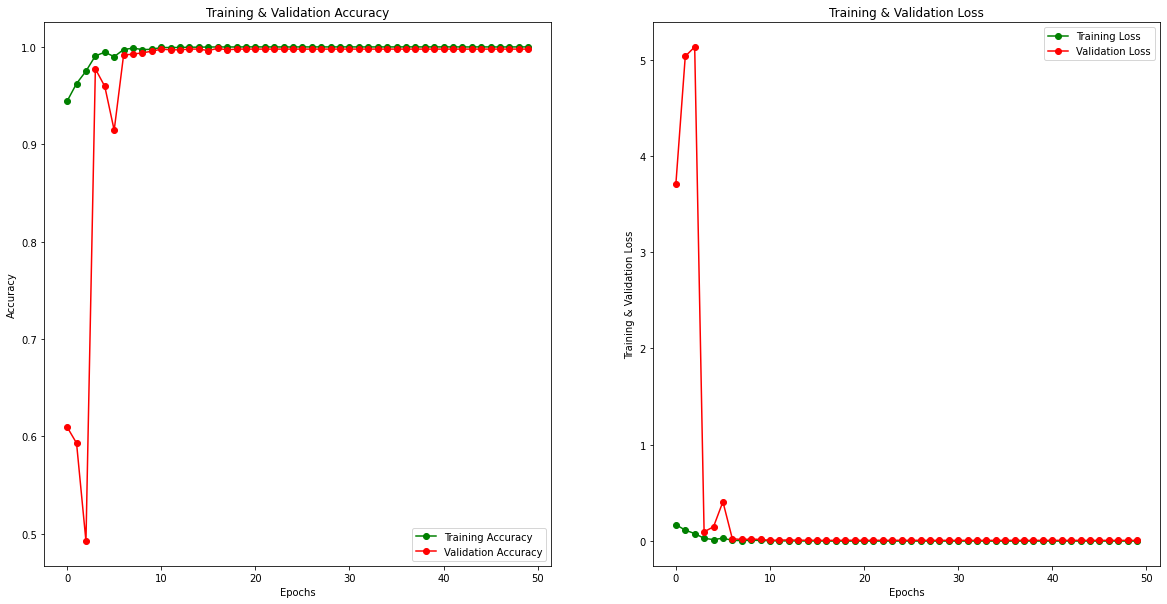

In [ ]:
plot_accuracy_loss_chart(history)

In [ ]:
%%time
results = model.evaluate(test_images, test_labels)
# results = model.evaluate(test_ds)

print("Loss of test model is  ", results[0])
print("Accuracy of test model is ", results[1]*100, "%")


# results = model.evaluate(val_images, val_labels)

# print("Loss of validation model is ", results[0])
# print("Accuracy of validation model is ", results[1]*100, "%")

# results = model.evaluate(train_images, train_labels)

# print("Loss of train model  is ", results[0])
# print("Accuracy of train model is ", results[1]*100, "%")

24/24 [==============================] - 1s 16ms/step - loss: 12.6448 - accuracy: 0.0784
Loss of test model is   12.644791603088379
Accuracy of test model is  7.8378379344940186 %
CPU times: user 1.48 s, sys: 47.9 ms, total: 1.53 s
Wall time: 1.41 s


In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([0, 8, 9, 7, 8, 9, 0, 9, 9, 9, 7, 0, 9, 7, 6])

In [ ]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = class_names))

                 precision    recall  f1-score   support

     1 Hầu họng       0.10      0.26      0.15        74
    2 Thực quản       0.00      0.00      0.00        74
       3 Tâm vị       0.00      0.00      0.00        74
      4 Thân vị       0.00      0.00      0.00        74
     5 Phình vị       0.00      0.00      0.00        74
      6 Hang vị       0.13      0.16      0.14        74
  7 Bờ cong lớn       0.03      0.01      0.02        74
  8 Bờ cong nhỏ       0.03      0.11      0.05        74
9 Hành tá tràng       0.18      0.24      0.21        74
    10 Tá tràng       0.00      0.00      0.00        74

       accuracy                           0.08       740
      macro avg       0.05      0.08      0.06       740
   weighted avg       0.05      0.08      0.06       740



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(test_labels, predictions)
def calculate_sen_spec(cm):
    size = len(cm)
    TP, F, TN, TF, f1score, total = 0, 0, 0, 0, 0, 0
    total += sum([sum([cm[i][j] for i in range(size)]) for j in range(size)])
    TP += sum([cm[i][i] for i in range(size)])
    F = total - TP
    TN = (size-2)*total+TP
    sen = TP/(TP+F)
    spec = TN/(TN+F)
    acc = (TP+TN)/(size*total)
    pre = TP/(TP+F)
    f1score = 2*TP/(2*TP+2*F)

    return sen, spec, acc, pre, f1score
calculate_sen_spec(cm)

(0.07837837837837838,
 0.8975975975975976,
 0.8156756756756757,
 0.07837837837837838,
 0.07837837837837838)

In [ ]:
cm

array([[19,  0,  0,  0,  0,  0,  2, 16,  3, 34],
       [15,  0,  0,  0,  0,  0,  0,  7, 52,  0],
       [38,  0,  0,  0,  0,  0, 22, 10,  4,  0],
       [15,  0,  0,  0,  0,  4,  3, 47,  5,  0],
       [ 0,  1,  0,  0,  0,  6,  2, 64,  0,  1],
       [ 9,  0,  0,  0,  0, 12,  1, 39, 13,  0],
       [47,  0,  0,  0,  0, 14,  1,  9,  3,  0],
       [11, 50,  0,  0,  0,  4,  1,  8,  0,  0],
       [21,  2,  0,  0,  0,  2,  1, 30, 18,  0],
       [ 7,  0,  0,  0,  0, 52,  0, 15,  0,  0]])

In [ ]:
cm = pd.DataFrame(cm, index = class_names, columns = class_names)
cm

,1 Hầu họng,2 Thực quản,3 Tâm vị,4 Thân vị,5 Phình vị,6 Hang vị,7 Bờ cong lớn,8 Bờ cong nhỏ,9 Hành tá tràng,10 Tá tràng
1 Hầu họng,19,0,0,0,0,0,2,16,3,34
2 Thực quản,15,0,0,0,0,0,0,7,52,0
3 Tâm vị,38,0,0,0,0,0,22,10,4,0
4 Thân vị,15,0,0,0,0,4,3,47,5,0
5 Phình vị,0,1,0,0,0,6,2,64,0,1
6 Hang vị,9,0,0,0,0,12,1,39,13,0
7 Bờ cong lớn,47,0,0,0,0,14,1,9,3,0
8 Bờ cong nhỏ,11,50,0,0,0,4,1,8,0,0
9 Hành tá tràng,21,2,0,0,0,2,1,30,18,0
10 Tá tràng,7,0,0,0,0,52,0,15,0,0


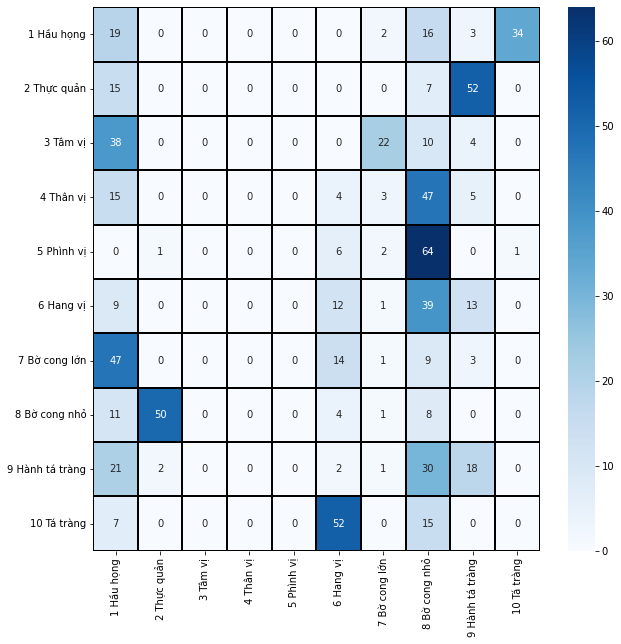

In [ ]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

# Model Quantization Aware Training

### Encoding label

In [ ]:
# One hot encoding
def labelEncoder(label):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(label)


    onehot_encoder = OneHotEncoder(sparse=False)
    # onehot_encoder = OneHotEncoder(sparse=False,dtype=np.uint8)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    encoded_label = onehot_encoded

    return encoded_label

In [ ]:
train_labels = labelEncoder(train_labels)
val_labels = labelEncoder(val_labels)


### Define Quantization Aware Training model

In [ ]:
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model

In [ ]:
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

In [ ]:
def setup_mobilenet_v2_model():
    base_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                   input_shape=(Train_SIZE, Train_SIZE, 3),
                                                   weights='imagenet')
    base_output = base_model.layers[-2]
    outputs = tf.keras.layers.Dense(nb_classes,
                                    activation='softmax')(base_output.output)
    model = tf.keras.models.Model(inputs=base_model.inputs,
                                  outputs=outputs)
    return model

In [ ]:
base = setup_mobilenet_v2_model()
qat_model = quantize_model(base)

/usr/local/lib/python3.7/dist-packages/keras/layers/wrappers.py:64: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  config = {'layer': generic_utils.serialize_keras_object(self.layer)}
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
qat_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 quantize_layer (QuantizeLayer)  (None, 128, 128, 3)  3          ['input_1[0][0]']                
                                                                                                  
 quant_Conv1 (QuantizeWrapperV2  (None, 64, 64, 32)  929         ['quantize_layer[1][0]']         
 )                                                                                                
                                                                                              

### Training

In [ ]:
qat_model.compile (
                  optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                )

In [ ]:
qat_hist = qat_model.fit(
                    train_images, 
                    train_labels, 
                    # train_loader,
                    batch_size = 32, 
                    epochs = EPOCHS, 
                    validation_data=(val_images, val_labels),   
                    # validation_data=test_loader,  
                    callbacks=[
                         ModelCheckpoint(
                                            filepath='/content/drive/MyDrive/best_model_BAC_aff_quant.hdf5',
                                            save_best_only=True,
                                            save_weights_only=False),
                         ReduceLROnPlateau(
                                            monitor = 'val_loss', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.000001),
                        ModelCheckpoint(
                                            filepath='/content/drive/MyDrive/last_model_BAC_aff_quant.hdf5', 
                                            save_best_only=False,
                                            save_weights_only=False)
                        ]

)

Epoch 1/50
910/910 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.8980

/usr/local/lib/python3.7/dist-packages/keras/layers/wrappers.py:64: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  config = {'layer': generic_utils.serialize_keras_object(self.layer)}


910/910 [==============================] - 284s 288ms/step - loss: 0.3069 - accuracy: 0.8980 - val_loss: 16.3673 - val_accuracy: 0.1166 - lr: 0.0010
Epoch 2/50
910/910 [==============================] - 258s 283ms/step - loss: 0.1286 - accuracy: 0.9583 - val_loss: 11.4517 - val_accuracy: 0.3074 - lr: 0.0010
Epoch 3/50
910/910 [==============================] - 258s 284ms/step - loss: 0.0956 - accuracy: 0.9688 - val_loss: 2.3195 - val_accuracy: 0.6841 - lr: 0.0010
Epoch 4/50
910/910 [==============================] - 257s 282ms/step - loss: 0.0873 - accuracy: 0.9720 - val_loss: 1.3937 - val_accuracy: 0.7922 - lr: 0.0010
Epoch 5/50
910/910 [==============================] - 255s 280ms/step - loss: 0.0965 - accuracy: 0.9694 - val_loss: 5.4109 - val_accuracy: 0.5287 - lr: 0.0010
Epoch 6/50
910/910 [==============================] - 256s 281ms/step - loss: 0.0635 - accuracy: 0.9790 - val_loss: 0.1734 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 7/50
910/910 [==============================] - 2

### Save model

In [ ]:
qat_model.save('/content/drive/MyDrive/MICA/Models/mobilenetv2_qat_08012022')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MICA/Models/mobilenetv2_qat_08012022/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MICA/Models/mobilenetv2_qat_08012022/assets
/usr/local/lib/python3.7/dist-packages/keras/layers/wrappers.py:64: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  config = {'layer': generic_utils.serialize_keras_object(self.layer)}
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
qat_model_dir = '/content/drive/MyDrive/MICA/Models/mobilenetv2_qat_08012022'
tflite_models_dir = pathlib.Path('/content/drive/MyDrive/MICA/Models/mobilenetv2_post_quant')

converter = tf.lite.TFLiteConverter.from_saved_model(qat_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = tflite_models_dir/"mobilenetv2_qat_08012022.tflite"
tflite_model_file.write_bytes(tflite_model)

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
!du -h /content/drive/MyDrive/MICA/Models/mobilenetv2_post_quant/mobilenetv2_qat_08012022.tflite

2.6M	/content/drive/MyDrive/MICA/Models/mobilenetv2_post_quant/mobilenetv2_qat_08012022.tflite


### Evaluation

#### Accuracy loss chart

In [ ]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(EPOCHS)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

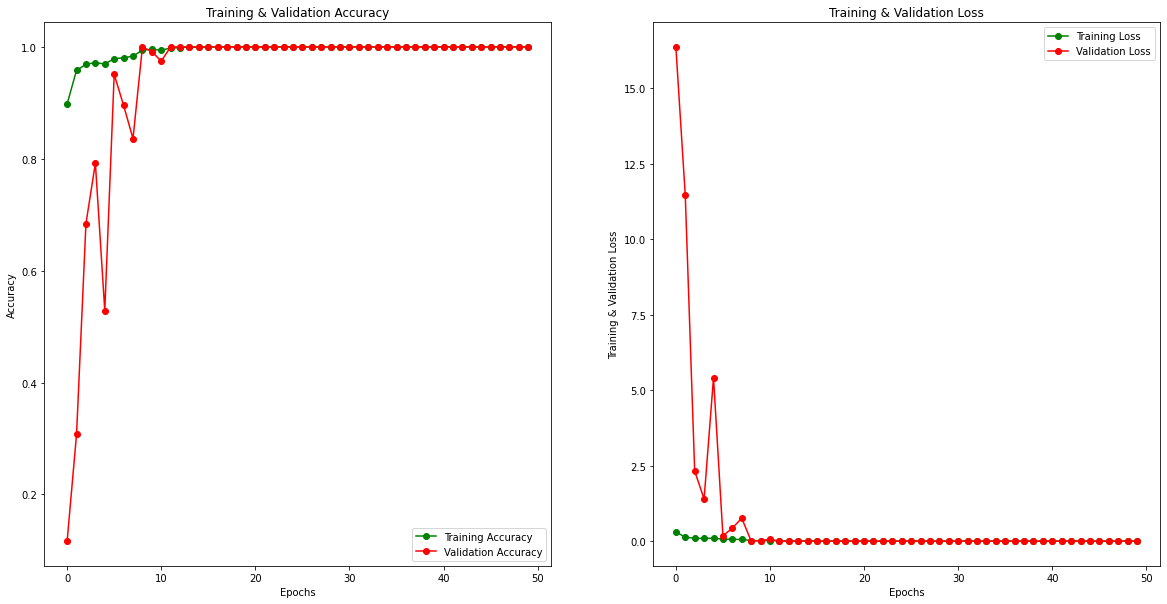

In [ ]:
plot_accuracy_loss_chart(qat_hist)

#### Accuracy

In [ ]:
test_labels = labelEncoder(test_labels)

In [ ]:
%%time
results = qat_model.evaluate(test_images, test_labels)

print("Loss of test model is  ", results[0])
print("Accuracy of test model is ", results[1]*100, "%")

24/24 [==============================] - 3s 108ms/step - loss: 0.2114 - accuracy: 0.9703
Loss of test model is   0.21143560111522675
Accuracy of test model is  97.02702760696411 %
CPU times: user 3.9 s, sys: 2.09 s, total: 5.99 s
Wall time: 2.9 s


#### Classification Report

In [ ]:
from sklearn.metrics import classification_report

predictions = qat_model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

test_labels_rounded = np.argmax(test_labels, axis=1)

print(classification_report(
    test_labels_rounded, 
    predictions, 
    target_names = class_names))

                 precision    recall  f1-score   support

     1 Hầu họng       1.00      1.00      1.00        74
    2 Thực quản       1.00      1.00      1.00        74
       3 Tâm vị       1.00      1.00      1.00        74
      4 Thân vị       0.85      0.86      0.86        74
     5 Phình vị       1.00      0.96      0.98        74
      6 Hang vị       0.96      0.95      0.95        74
  7 Bờ cong lớn       0.91      0.97      0.94        74
  8 Bờ cong nhỏ       1.00      0.97      0.99        74
9 Hành tá tràng       1.00      0.99      0.99        74
    10 Tá tràng       0.99      1.00      0.99        74

       accuracy                           0.97       740
      macro avg       0.97      0.97      0.97       740
   weighted avg       0.97      0.97      0.97       740



#### Confusion matrix

In [ ]:
cm = confusion_matrix(test_labels_rounded, predictions)
def calculate_sen_spec(cm):
    size = len(cm)
    TP, F, TN, TF, f1score, total = 0, 0, 0, 0, 0, 0
    total += sum([sum([cm[i][j] for i in range(size)]) for j in range(size)])
    TP += sum([cm[i][i] for i in range(size)])
    F = total - TP
    TN = (size-2)*total+TP
    sen = TP/(TP+F)
    spec = TN/(TN+F)
    acc = (TP+TN)/(size*total)
    pre = TP/(TP+F)
    f1score = 2*TP/(2*TP+2*F)

    return sen, spec, acc, pre, f1score
calculate_sen_spec(cm)

(0.9702702702702702,
 0.9966966966966967,
 0.994054054054054,
 0.9702702702702702,
 0.9702702702702702)

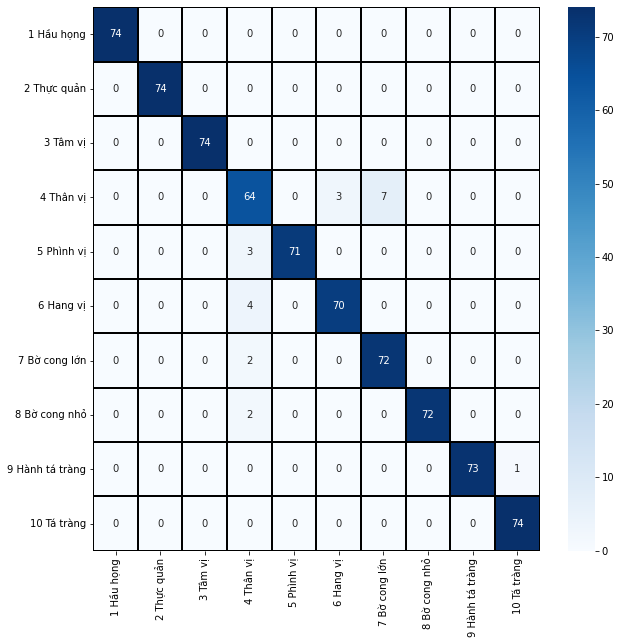

In [ ]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
cm = pd.DataFrame(cm, index = class_names, columns = class_names)
plot_confusion_matrix(cm)

# Model Post-training quantization

In [ ]:
# Path to original model
saved_model_dir = '/content/drive/MyDrive/MICA/Models/mobilenetv2_og'

## Dynamic range quantization

In [ ]:
tflite_models_dir = pathlib.Path('/content/drive/MyDrive/MICA/Models/mobilenetv2_post_quant')

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

tflite_model = converter.convert()
tflite_model_file = tflite_models_dir/"mobilenetv2.tflite"
tflite_model_file.write_bytes(tflite_model)

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

tflite_model_quant_file = tflite_models_dir/"mobilenetv2_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [ ]:
print("Accuracy (og model): ", evaluate_model(interpreter)*100, "%")
print("Accuracy (quantized model): ", evaluate_model(interpreter_quant)*100, "%")

Accuracy (og model):  97.2972972972973 %
Accuracy (quantized model):  97.2972972972973 %


# Models' size

In [ ]:
!ls -lh /content/drive/MyDrive/MICA/Models/mobilenetv2_post_quant/

total 51M
-rw------- 1 root root 2.6M Jan  8 05:41 mobilenetv2_qat_08012022.tflite
-rw------- 1 root root  18M Dec 29 04:27 mobilenetv2_qat_29122021.tflite
-rw------- 1 root root 2.6M Dec 31 16:33 mobilenetv2_qat_31122021.tflite
-rw------- 1 root root  18M Dec 27 10:20 mobilenetv2_qat.tflite
-rw------- 1 root root 2.6M Nov 21 15:41 mobilenetv2_quant.tflite
-rw------- 1 root root 8.6M Nov 21 15:41 mobilenetv2.tflite


In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [ ]:
tflite_model_filepath = '/content/drive/MyDrive/MICA/Models/mobilenetv2_post_quant/mobilenetv2.tflite'

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_filepath))
interpreter.allocate_tensors()

In [ ]:
print("Accuracy: ", evaluate_model(interpreter)*100, "%")

Accuracy:  97.2972972972973 %


In [28]:
path_to_eval = '/content/drive/MyDrive/MICA/Models/mobilenetv2_og'
model_to_eval = keras.models.load_model(path_to_eval)

In [29]:
results = model_to_eval.evaluate(test_images, test_labels)

print("Loss of test model is  ", results[0])
print("Accuracy of test model is ", results[1]*100, "%")

24/24 [==============================] - 21s 30ms/step - loss: 0.2008 - accuracy: 0.9730
Loss of test model is   0.20080716907978058
Accuracy of test model is  97.29729890823364 %


In [30]:
!zip -rv mobilenetv2_model.zip /content/drive/MyDrive/MICA/Models/mobilenetv2_og

  adding: content/drive/MyDrive/MICA/Models/mobilenetv2_og/	(in=0) (out=0) (stored 0%)
  adding: content/drive/MyDrive/MICA/Models/mobilenetv2_og/variables/	(in=0) (out=0) (stored 0%)
  adding: content/drive/MyDrive/MICA/Models/mobilenetv2_og/variables/variables.data-00000-of-00001 ..	(in=27114733) (out=25033167) (deflated 8%)
  adding: content/drive/MyDrive/MICA/Models/mobilenetv2_og/variables/variables.index	(in=37818) (out=7940) (deflated 79%)
  adding: content/drive/MyDrive/MICA/Models/mobilenetv2_og/assets/	(in=0) (out=0) (stored 0%)
  adding: content/drive/MyDrive/MICA/Models/mobilenetv2_og/saved_model.pb 	(in=4336712) (out=356398) (deflated 92%)
  adding: content/drive/MyDrive/MICA/Models/mobilenetv2_og/keras_metadata.pb 	(in=525113) (out=20962) (deflated 96%)
total bytes=32014376, compressed=25418467 -> 21% savings
